In [1]:
# Import Libraries 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dense, Dropout, LSTM, Bidirectional, concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

2023-05-06 14:23:39.038922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("imdb.csv", encoding = 'utf-8')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
for i in range(5):
    print("Review: ", [i])
    print(df['review'].iloc[i], "\n")
    print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")

Review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [4]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [5]:
df['word count'] = df['review'].apply(no_of_words)

In [6]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  419


In [7]:
# drop any rows with missing values

df = df.dropna(subset=['review'])

In [10]:
#  preprocessing and cleansing step aims to remove any unnecessary characters and information from the text
#  tokenize the text into individual words
#  remove any words that are not useful for predicting the sentiment of the text.


#2
def preprocessing(texts):
    texts = re.sub(r'<.*?>', '', texts)       # regular expression to remove all HTML tags from the text
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)  # replaces any character that is not a letter (a-z, A-Z) with a space
    
    texts = texts.lower()                     # converts all text to lowercase
    texts = re.sub('<br />', '', texts)       # removes any remaining HTML line breaks
    texts = re.sub(r"http\S+|www\S+|https\S+", '', texts, flags=re.MULTILINE)   #  removes any URLs present in the text
    texts = re.sub(r'\@w+|\#','', texts)      # removes any mentions of Twitter handles or hashtags
    texts = re.sub(r'[^\w\s]','', texts)      # removes any non-alphanumeric characters from the text

    texts_tokens = word_tokenize(texts)       # tokenizes the text into individual words
    filtered_texts = [w for w in texts_tokens if not w in stop_words]           # removes any stop words from the text, which are common words like "the", "and", and "is" that do not provide significant meaning to the text
    return ' '.join(x.lower() for x in texts.split())                           # returns the original text in all lowercase, with any remaining whitespace reduced to a single space

#3 
    return " ".join(filtered_text)            # returns the filtered text with stop words removed

#2
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing(x))

In [11]:
# Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['review'])
X = tokenizer.texts_to_sequences(df['review'])
X = pad_sequences(X, maxlen=500)


In [12]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['review']).toarray()
X_tfidf = pad_sequences(X_tfidf, maxlen=500)

In [14]:
# GloVe word embedding
EMBEDDING_DIM = 32
word_index = tokenizer.word_index
num_words = min(5000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
with open('glove.6B.100d.txt', encoding = ' utf-8') as f:
    for line in f:
        word, *vector = line.split()
        if word in word_index:
            idx = word_index[word]
            if idx < num_words:
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:EMBEDDING_DIM]

In [15]:
y = df['sentiment'].replace({'positive': 1, 'negative': 0}).values

In [16]:
#X_train_tfidf, X_test_tfidf, X_train, X_test, y_train, y_test = train_test_split(X_tfidf, X, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_tfidf, X, y, test_size=0.2, random_state=42)

In [17]:
# CNN model
input_cnn = Input(shape=(500,))
embedding_cnn = Embedding(input_dim=5000, output_dim=32, input_length=500, weights=[embedding_matrix])(input_cnn)
conv1d_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_cnn)
pooling_1 = MaxPooling1D(pool_size=2)(conv1d_1)
conv1d_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(pooling_1)
pooling_2 = MaxPooling1D(pool_size=2)(conv1d_2)
flatten_1 = tf.keras.layers.Flatten()(pooling_2)
dense_1 = Dense(32, activation='relu')(flatten_1)
dropout_1 = Dropout(0.5)(dense_1)

2023-05-06 14:00:37.239498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Stack Bi-LSTM model
input_lstm = Input(shape=(500,))
embedding_lstm = Embedding(input_dim=5000, output_dim=32, input_length=500, weights=[embedding_matrix])(input_lstm)
lstm_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_lstm)
lstm_2 = Bidirectional(LSTM(32))(lstm_1)
dropout_2 = Dropout(0.5)(lstm_2)

In [21]:
# Ensemble model
concatenated = concatenate([dropout_1, dropout_2])
dense_2 = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense_2)

In [22]:
model = Model(inputs=[input_cnn, input_lstm], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

def check_percent_diff(epoch, logs):
    current_val_acc = logs['val_accuracy']
    current_train_acc = logs['accuracy']
    percent_diff = abs(current_val_acc - current_train_acc) / current_train_acc * 100
    
    if percent_diff > 5:
        check_percent_diff.count += 1
        if check_percent_diff.count > 5:
            print(f"Percentage difference exceeded 5% for more than 5 epochs. Stopping training...")
            self.model.stop_training = True
    else:
        check_percent_diff.count = 0

check_percent_diff.count = 0

history = model.fit([X_train_tfidf, X_train_lstm], y_train, validation_data=([X_test_tfidf, X_test_lstm], y_test), epochs=10, batch_size=128, callbacks = [early_stopping, tf.keras.callbacks.LambdaCallback(on_epoch_end=check_percent_diff)]
)



Epoch 1/10
313/313 [==============================] - 1526s 5s/step - loss: 0.5933 - accuracy: 0.6849 - val_loss: 0.5345 - val_accuracy: 0.7416
Epoch 2/10
313/313 [==============================] - 1253s 4s/step - loss: 0.4098 - accuracy: 0.8241 - val_loss: 0.3502 - val_accuracy: 0.8457
Epoch 3/10
313/313 [==============================] - 1203s 4s/step - loss: 0.3185 - accuracy: 0.8729 - val_loss: 0.2917 - val_accuracy: 0.8860
Epoch 4/10
313/313 [==============================] - 1273s 4s/step - loss: 0.2684 - accuracy: 0.8976 - val_loss: 0.2679 - val_accuracy: 0.8919
Epoch 5/10
313/313 [==============================] - 1167s 4s/step - loss: 0.2396 - accuracy: 0.9084 - val_loss: 0.2429 - val_accuracy: 0.9007
Epoch 6/10
313/313 [==============================] - 1214s 4s/step - loss: 0.2168 - accuracy: 0.9180 - val_loss: 0.2448 - val_accuracy: 0.9052
Epoch 7/10
313/313 [==============================] - 1198s 4s/step - loss: 0.2010 - accuracy: 0.9255 - val_loss: 0.2276 - val_accuracy:

In [22]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.593274  0.684900  0.534534        0.7416
1  0.409793  0.824075  0.350224        0.8457
2  0.318483  0.872875  0.291734        0.8860
3  0.268447  0.897600  0.267936        0.8919
4  0.239598  0.908400  0.242899        0.9007
5  0.216819  0.917975  0.244782        0.9052
6  0.200978  0.925475  0.227550        0.9073
7  0.185524  0.931975  0.225137        0.9094
8  0.174419  0.937025  0.234903        0.9102
9  0.165671  0.940900  0.241359        0.9046


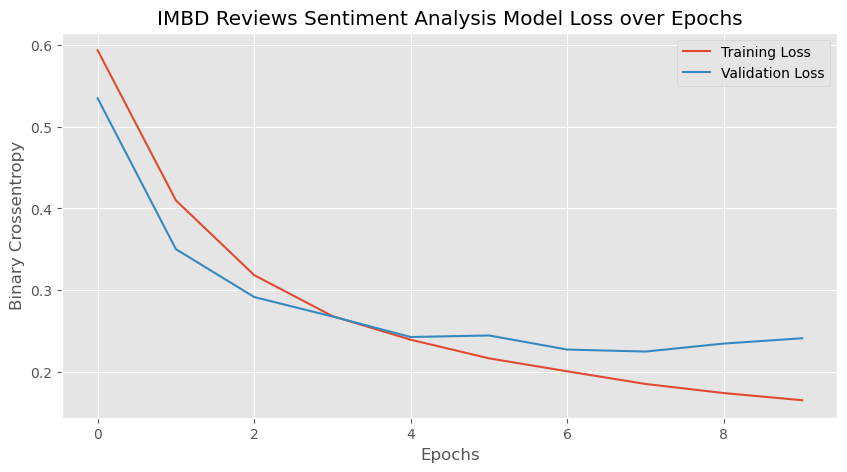

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('IMBD Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

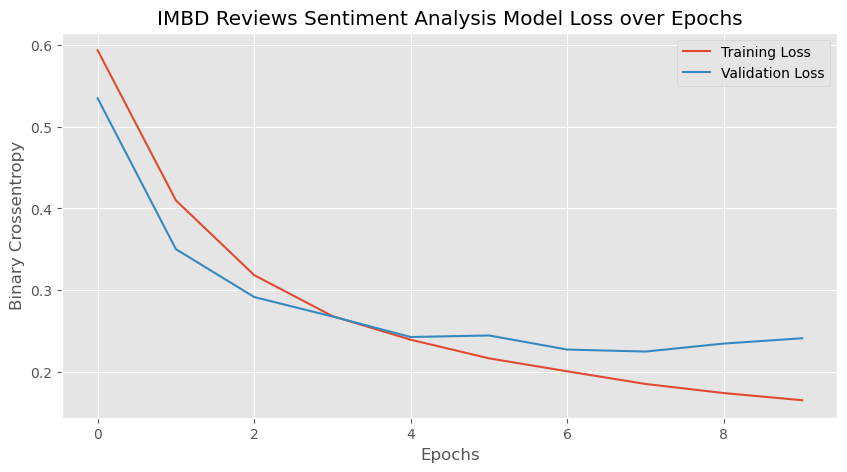

In [24]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('IMBD Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [25]:
# Evaluate model on text set

from sklearn.metrics import accuracy_score

y_pred = model.predict([X_test_tfidf, X_test_lstm])
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: %.2f%%" % (accuracy*100))

313/313 [==============================] - 37s 118ms/step
Accuracy: 90.46%


In [26]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4961
           1       0.88      0.94      0.91      5039

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

